In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing import event_accumulator
from pathlib import Path
import numpy as np

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

In [14]:
def load_tensorboard_data(run_dir, metric='charts/episodic_return'):
    """Load specific metric from TensorBoard event files"""
    ea = event_accumulator.EventAccumulator(run_dir)
    ea.Reload()
    
    if metric not in ea.Tags()['scalars']:
        return None
    
    events = ea.Scalars(metric)
    return pd.DataFrame([(e.step, e.value) for e in events], columns=['step', 'value'])

def parse_run_name(run_name):
    """Extract game, algorithm, seed from run directory name"""
    # Pattern: GameName__algorithm_info__seed__timestamp
    parts = run_name.split('__')
    game = parts[0].replace('NoFrameskip-v4', '')
    
    # Determine algorithm
    algo_part = parts[1]
    if 'cf_dqn' in algo_part:
        # Extract CF-DQN variant (e.g., cf_dqn_freq64_max2)
        if 'freq' in algo_part:
            freq_match = re.search(r'freq(\d+)', algo_part)
            max_match = re.search(r'max(\d+)', algo_part)
            freq = freq_match.group(1) if freq_match else 'unknown'
            max_k = max_match.group(1) if max_match else 'unknown'
            algo = f'CF-DQN (f={freq}, k={max_k})'
        else:
            algo = 'CF-DQN'
    elif 'c51' in algo_part:
        algo = 'C51'
    elif 'dqn' in algo_part:
        algo = 'DQN'
    else:
        algo = algo_part
    
    # Extract seed
    seed_match = re.search(r'seed(\d+)', run_name)
    seed = int(seed_match.group(1)) if seed_match else 1
    
    return game, algo, seed

# Define the valid experiments from the batch scripts
# Games: Breakout, Asterix, Seaquest, Qbert
# Baselines: c51_seed{1,2,3}, dqn_seed{1,2,3} for each game
# CF-DQN: cf_dqn_freq{32,64}_max{2,5}_seed{1,2,3} for each game
valid_exp_names = set()
games = ['Breakout', 'Asterix', 'Seaquest', 'Qbert']
for game in games:
    for seed in [1, 2, 3]:
        valid_exp_names.add(f"{game}NoFrameskip-v4__c51_seed{seed}")
        valid_exp_names.add(f"{game}NoFrameskip-v4__dqn_seed{seed}")
        for freq in [32, 64]:
            for max_k in [2, 5]:
                valid_exp_names.add(f"{game}NoFrameskip-v4__cf_dqn_freq{freq}_max{max_k}_seed{seed}")

# Load all runs data (filter to valid experiments)
runs_dir = Path('runs')
all_data = []

for run_path in runs_dir.iterdir():
    if not run_path.is_dir():
        continue
    
    # Check if this run matches our valid experiments
    run_prefix = '__'.join(run_path.name.split('__')[:2])
    if run_prefix not in valid_exp_names:
        continue
    
    game, algo, seed = parse_run_name(run_path.name)
    df = load_tensorboard_data(str(run_path))
    
    if df is not None and len(df) > 0:
        df['game'] = game
        df['algorithm'] = algo
        df['seed'] = seed
        all_data.append(df)

data = pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()
print(f"Loaded data from {len(all_data)} runs")
print(f"Games: {sorted(data['game'].unique())}")
print(f"Algorithms: {sorted(data['algorithm'].unique())}")

Loaded data from 76 runs
Games: ['Asterix', 'Breakout', 'Qbert', 'Seaquest']
Algorithms: ['C51', 'CF-DQN (f=32, k=2)', 'CF-DQN (f=32, k=5)', 'CF-DQN (f=64, k=2)', 'CF-DQN (f=64, k=5)', 'DQN']


In [17]:
mins = data.groupby(['game', 'algorithm']).step.max().groupby('game').min()
games_data = []
for game, min_step in mins.items():
    games_data.append(data[(data['game'] == game) & (data['step'] <= min_step)])
data = pd.concat(games_data, ignore_index=True)

In [18]:
data

,step,value,game,algorithm,seed
0,247,250.0,Asterix,C51,1
1,503,150.0,Asterix,C51,1
2,751,300.0,Asterix,C51,1
3,955,100.0,Asterix,C51,1
4,1137,200.0,Asterix,C51,1
...,...,...,...,...,...
326620,3463262,560.0,Seaquest,"CF-DQN (f=32, k=5)",3
326621,3465226,640.0,Seaquest,"CF-DQN (f=32, k=5)",3
326622,3467853,920.0,Seaquest,"CF-DQN (f=32, k=5)",3
326623,3469825,640.0,Seaquest,"CF-DQN (f=32, k=5)",3


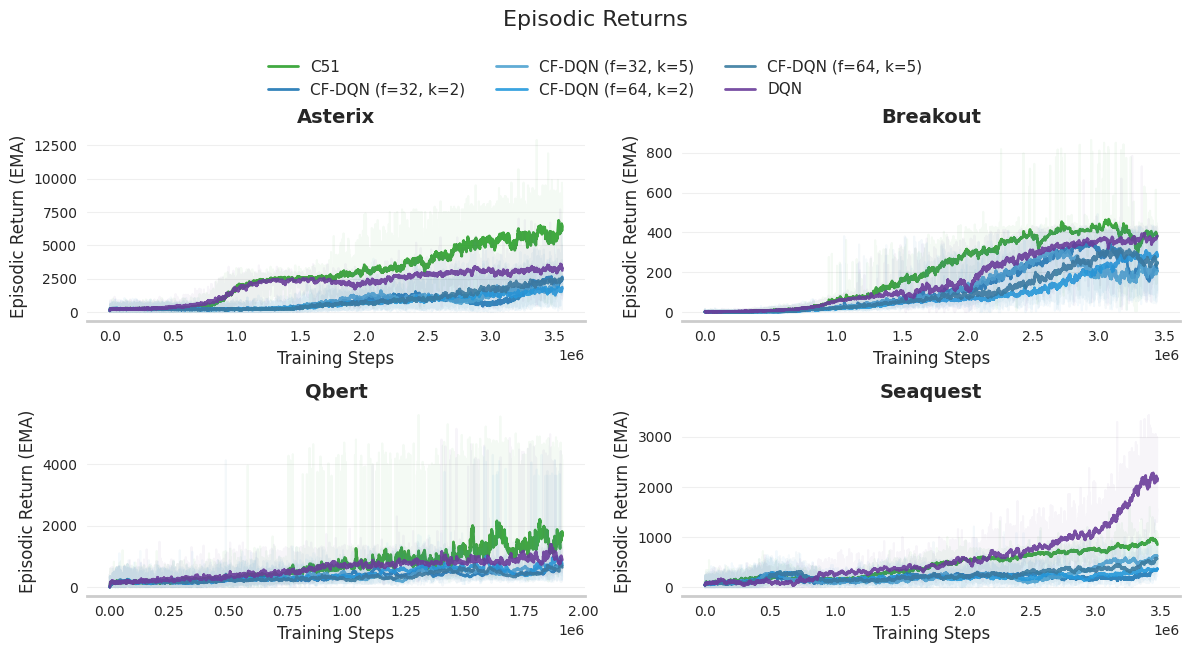


Plot saved as 'reward_comparison_all_games.png' (EMA α=0.05)


In [27]:
# Separate baselines (DQN, C51) from CF-DQN variants
baseline_algos = ['DQN', 'C51']
games = sorted(data['game'].unique())

# EMA smoothing parameter
ema_alpha = 0.05  # Adjust this parameter to control smoothing

def apply_ema(series, alpha=0.1):
    """Apply exponential moving average with given alpha"""
    return series.ewm(alpha=alpha, adjust=False).mean()

# Color palette:
# 4 blues for non-baselines, purple + green for baselines
non_baseline_colors = ['#1f77b4', '#4fa3d1', "#259add", "#3a7ca0"]
baseline_colors = {
    'DQN': '#6a3d9a',   # purple
    'C51': '#2ca02c',   # green
}

# Create one subplot per game
n_games = len(games)
cols = 2
rows = (n_games + 1) // 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten() if n_games > 1 else [axes]

for idx, game in enumerate(games):
    ax = axes[idx]
    game_data = data[data['game'] == game]

    non_baseline_idx = 0

    for algo in sorted(game_data['algorithm'].unique()):
        algo_data = game_data[game_data['algorithm'] == algo]

        # Average across seeds
        grouped = algo_data.groupby('step')['value'].mean().reset_index()

        # Apply EMA smoothing
        grouped['value_smoothed'] = apply_ema(grouped['value'], alpha=ema_alpha)

        # Assign colors
        if algo in baseline_algos:
            color = baseline_colors[algo]
        else:
            color = non_baseline_colors[non_baseline_idx % len(non_baseline_colors)]
            non_baseline_idx += 1

        # Plot original curve with low opacity
        ax.plot(
            grouped['step'],
            grouped['value'],
            alpha=0.05,
            color=color,
            linewidth=1.5,
        )

        # Plot smoothed curve
        ax.plot(
            grouped['step'],
            grouped['value_smoothed'],
            label=algo,
            alpha=0.9,
            color=color,
            linewidth=2.0,
        )

    ax.set_xlabel('Training Steps', fontsize=12)
    ax.set_ylabel('Episodic Return (EMA)', fontsize=12)
    ax.set_title(f'{game}', fontsize=14, fontweight='bold')

    # Grid: horizontal only
    ax.grid(True, axis='y', alpha=0.3)
    ax.grid(False, axis='x')

    # Spine styling
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Hide extra subplots
for idx in range(n_games, len(axes)):
    axes[idx].axis('off')

# Global legend at top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    ncol=3,
    fontsize=11,
    frameon=False,
    bbox_to_anchor=(0.5, 1.02),
)

plt.suptitle(f'Episodic Returns', fontsize=16, y=1.08)
plt.tight_layout()
plt.savefig('reward_comparison_all_games.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as 'reward_comparison_all_games.png' (EMA α={ema_alpha})")

In [25]:
sorted(game_data['algorithm'].unique())

['C51',
 'CF-DQN (f=32, k=2)',
 'CF-DQN (f=32, k=5)',
 'CF-DQN (f=64, k=2)',
 'CF-DQN (f=64, k=5)',
 'DQN']

In [ ]:
# Summary statistics: final performance comparison
summary_data = []

for game in sorted(data['game'].unique()):
    game_data = data[data['game'] == game]
    
    for algo in sorted(game_data['algorithm'].unique()):
        algo_data = game_data[game_data['algorithm'] == algo]
        
        # Get final 10% of training for each seed
        final_data = []
        for seed in algo_data['seed'].unique():
            seed_data = algo_data[algo_data['seed'] == seed].sort_values('step')
            if len(seed_data) > 0:
                cutoff = int(len(seed_data) * 0.9)
                final_returns = seed_data.iloc[cutoff:]['value'].mean()
                final_data.append(final_returns)
        
        if final_data:
            summary_data.append({
                'Game': game,
                'Algorithm': algo,
                'Mean Final Return': np.mean(final_data),
                'Std Final Return': np.std(final_data),
                'Seeds': len(final_data)
            })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(['Game', 'Mean Final Return'], ascending=[True, False])

print("\n=== Final Performance Summary (Last 10% of Training) ===")
print(summary_df.to_string(index=False))

# Highlight best performing algorithm per game
print("\n=== Best Algorithm per Game ===")
best_per_game = summary_df.loc[summary_df.groupby('Game')['Mean Final Return'].idxmax()]
print(best_per_game[['Game', 'Algorithm', 'Mean Final Return']].to_string(index=False))


=== Final Performance Summary (Last 10% of Training) ===
    Game          Algorithm  Mean Final Return  Std Final Return  Seeds
 Asterix                C51        7716.958663       1569.995715      3
 Asterix                DQN        5444.049679        611.075905      3
 Asterix CF-DQN (f=64, k=5)        1971.661376        329.780050      3
 Asterix CF-DQN (f=64, k=2)        1604.255464        152.240134      3
 Asterix CF-DQN (f=32, k=5)        1574.589145        297.421286      3
 Asterix CF-DQN (f=32, k=2)        1535.573174        725.962462      3
Breakout                C51         404.869500          1.948604      3
Breakout                DQN         360.349745          2.463301      3
Breakout CF-DQN (f=32, k=2)         254.002424         27.342742      3
Breakout CF-DQN (f=32, k=5)         228.534455          2.232976      3
Breakout CF-DQN (f=64, k=5)         177.625031         10.702186      3
Breakout CF-DQN (f=64, k=2)         165.863729         14.663169      3
   Qbe